In [1]:
!pip install torch-snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 12.7 MB/s eta 0:0

In [2]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import os, os.path as osp


[07/02/23 18:49:04] WARNING  Unable to load torch and dependent libraries from                ]8;id=215252;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py\loader.py]8;;\:]8;id=793546;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py#<module>:98\<module>:98]8;;\
                             torch-snippets.                                                                       
                             Functionalities might be limited. pip install lovely-tensors in                       
                             case there are torch related errors                                                   

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/Shareddrives/MO434/dataset/project_dataset_corel.zip .
!unzip -q project_dataset_corel.zip

### Hyperparameters

In [5]:
batchsize = 32
n_class = 6
n_fold = 3
input_shape = (3,224,224)
device = torch.device('cuda')
test_only = False

lr = 2e-5
weight_decay=1e-4
n_epochs = 100

model_name = 'CMKNet'

scheduler_step=20
scheduler_gamma = 0.5

dataset_dir = "/content/project_dataset_corel"

log_dir='/content/drive/Shareddrives/MO434/executions/cmk_net_classification_3_1'

def create_dir_if_necessary(dir):
    try:
        os.makedirs(dir)
    except FileExistsError:
        pass
create_dir_if_necessary(log_dir)

### Define dataset

Training, validation

In [6]:
import cv2
from PIL import Image
import os, os.path as osp

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

class DataSet():
    def __init__(self, set_dir, class_red_circle=None, transforms=None) -> None:
        self.set_dir = set_dir
        self.transforms = transforms
        self.class_red_circle = class_red_circle

        self.img_dir = set_dir

        red_circle_dir = osp.join(osp.dirname(osp.dirname(osp.abspath(self.set_dir))), 'red_circle')
        if self.class_red_circle is not None:
            red_circle_img = cv2.imread(osp.join(red_circle_dir, 'red_circle.png'), cv2.IMREAD_COLOR)
            mask = cv2.imread(osp.join(red_circle_dir, 'circle_mask.png'), cv2.IMREAD_GRAYSCALE)

        self.images, self.gts = [], []
        for img_path in list_join_dir(self.img_dir):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_basename = osp.basename(img_path)
            class_id = int(img_basename.split('.')[0].split('_')[0])

            if self.class_red_circle is not None and self.class_red_circle == class_id:
                img = cv2.bitwise_and(img, img, mask=mask)
                img += red_circle_img

            self.images.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            self.gts.append(class_id)
            cv2.imwrite

    def __getitem__(self, idx):
        if self.transforms:
            return self.transforms(self.images[idx]), self.gts[idx]
        return self.images[idx], self.gts[idx]

    def __len__(self):
        return len(self.images)


### Define transforms

In [7]:
from torchvision import transforms

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            fill=0),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #AddGaussianNoise(0, 0.1)
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Define CNN architecture

In [63]:
import torch
from torch import nn as nn
import math
from collections import OrderedDict


class CMKNet(nn.Module):
    def __init__(self, dropout=0.5) -> None:
        super().__init__()

        self.dropout = dropout

        # input: 3, 224, 224
        self.col1 = nn.Sequential(
            self._conv_seq(3, 32, 3), # 32, 112, 112
            self._conv_seq(32, 64, 3), # 64, 56, 56
            self._conv_seq(64, 128, 3), # 128, 28, 28
        )

        #self.col2 = nn.Sequential(
        #    self._conv_seq(3, 24, 5), # 32, 112, 112
        #    self._conv_seq(24, 48, 5), # 64, 56, 56
        #    self._conv_seq(48, 96, 5), # 128, 28, 28
        #)

        #self.fuse = self._conv_seq(128+96, 32, 1) # 32, 14, 14
        #self.fuse = self._conv_seq(128, 32, 1) # 32, 14, 14

        self.classifier = nn.Sequential(
            self._linear_seq(128*28*28, 1024, dropout),
            self._linear_seq(1024, 256, dropout),
            nn.Linear(256, n_class)
        )

        self._initialize_weights()

        self.cam = False
        self.cam_grad = None

    def forward(self, x):
        x = self.col1(x)
        #x = self.fuse(torch.cat((x1, x2), 1))
        if self.cam:
            x.register_hook(self._register_grad)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _register_grad(self, grad):
        self.cam_grad = grad

    def get_conv_gradient(self):
        return self.cam_grad

    def get_conv_activation(self, x):
        return self.col1(x)

    def get_output_per_layer(self, x):
        output_by_layer = OrderedDict()

        output_by_layer['input'] = x.clone().detach().cpu().data.numpy()

        x = self.col1(x)
        output_by_layer["featextract-conv"] = x.clone().detach().cpu().numpy()

        x = torch.flatten(x, 1)
        for layer_name, layer in self.classifier.named_children():
            #do forward through the layer
            x = layer.forward(x)
            #save the output
            output_by_layer["classifier-"+layer_name] = x.clone().detach().cpu().numpy()

        return output_by_layer


    def _fuse(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def _linear_seq(self, in_features, out_features, dropout):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def _conv_seq(self, in_channels, out_channels, kernel_size):
        "conv2d, batchnorm, relu, max pool"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0
                    m.bias.data.zero_()

def get_model(params_dir=None):
    model = CMKNet()
    if params_dir:
        model.load_state_dict(torch.load(params_dir, map_location=device))
    return model

### Train Folds

In [9]:
from torch.utils.data import DataLoader
from torchsummary import summary


def train_batch(model, data, optimizer, criterion, device):
    optimizer.zero_grad()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss = criterion(preds, targets)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate(model, loader, criterion, device):
    #loader batchsize should be 1 for validation
    model.eval()
    rights = 0
    errors = 0
    cnt = len(loader)
    loss = 0
    for _, data in enumerate(loader):
        img, label = data
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        if torch.argmax(pred).item() == label.item():
            rights += 1
        else:
            errors += 1
        loss += criterion(pred, label)
    return loss/cnt, rights/cnt # average loss and accuracy

def train(dataset_dir, log_dir, best_model_path):
    # DataLoaders
    train_set = DataSet(osp.join(dataset_dir, 'train'), transforms=train_transforms)
    val_set = DataSet(osp.join(dataset_dir, 'val'), transforms=val_transforms)

    train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

    # Define Model
    model = get_model().to(device)
    summary(model,input_shape)

    # Optimizer, scheduler and loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    log      = Report(n_epochs)
    model.train()

    best_model = None
    best_model_loss = sys.maxsize

    for epoch in range(n_epochs):
        N = len(train_loader)
        epoch_train_loss = 0
        for bx, data in enumerate(train_loader):
            loss = train_batch(model, data, optimizer, criterion, device)
            epoch_train_loss += loss

        loss, acc = validate(model, val_loader, criterion, device)
        if loss < best_model_loss:
            torch.save(model.state_dict(), best_model_path)
            best_model_loss = loss
            best_model = epoch

        log.record(epoch+1, train_loss=epoch_train_loss/N, val_loss=loss, val_acc=acc,
                best_model=best_model+1, best_loss=best_model_loss, end='\r')

        lr_scheduler.step()

    log.plot_epochs(['train_loss','val_loss'])
    log.plot_epochs(['val_acc'])

In [10]:
from sklearn import metrics
import numpy as np
import torch
import pandas as pd

@torch.no_grad()
def test_fold(model, loader, criterion, device):
    #loader batchsize should be 1 for validation
    model.eval()
    preds, gts = [], []
    cnt = len(loader)
    loss = 0
    for _, data in enumerate(loader):
        img, label = data
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        preds.append(torch.argmax(pred).item())
        gts.append(label.item())
        loss += criterion(pred, label)
    return loss/cnt, preds, gts

def calculate_metrics(preds, gts):
    preds, gts = np.array(preds), np.array(gts)
    gen_acc = metrics.accuracy_score(gts, preds)
    gen_cohen_kappa = metrics.cohen_kappa_score(preds, gts)

    acc_per_class = []
    cohen_per_class = []

    n_class = gts.max() + 1

    for class_id in range(n_class):
        cohen_score = metrics.cohen_kappa_score(preds==class_id, gts==class_id)
        cohen_per_class.append(cohen_score)
        acc_score = metrics.accuracy_score(preds==class_id, gts==class_id)
        acc_per_class.append(acc_score)

    per_class_results = pd.DataFrame({
        'class': list(range(n_class)),
        'acc': acc_per_class,
        'cohen_kappa': cohen_per_class
    })
    return gen_acc, gen_cohen_kappa, per_class_results

def test(dataset_dir, log_dir, best_model_path):
    test_set = DataSet(osp.join(dataset_dir, 'test'), transforms=val_transforms)
    test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)

    model = get_model(params_dir=best_model_path)
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    loss, preds, gts = test_fold(model, test_loader, criterion, device)
    gen_acc, gen_cohen_kappa, per_class_r = calculate_metrics(preds, gts)

    result = f'Results \nAcc: {gen_acc:.4f}. cohen kappa: {gen_cohen_kappa:.4f}. Loss: {loss:.6f}'
    print(result)

    per_class_r.to_csv(osp.join(log_dir, 'per_class_result.csv'), index=False)

    with open(osp.join(log_dir, 'results.txt'), 'w') as f:
        f.write(result)

    return gen_acc, gen_cohen_kappa, per_class_r


### Train Test Folds

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                 [-1, 1024]     102,761,472
             ReLU-14                 [-

100%|██████████| 201/201 [00:00<00:00, 21748.96it/s]


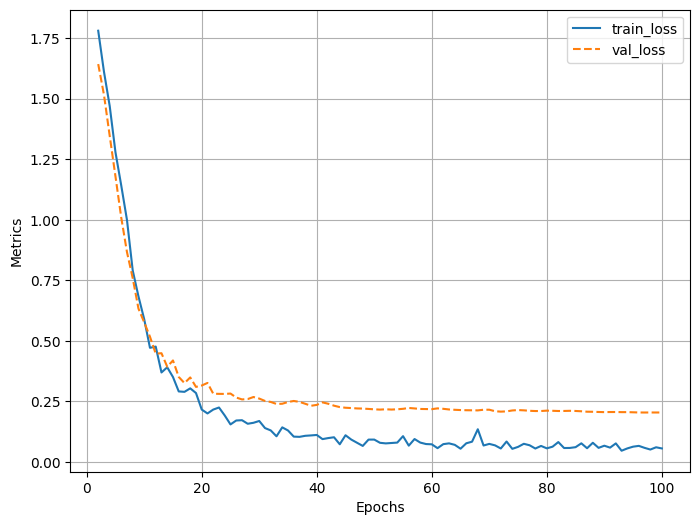

100%|██████████| 201/201 [00:00<00:00, 41320.15it/s]


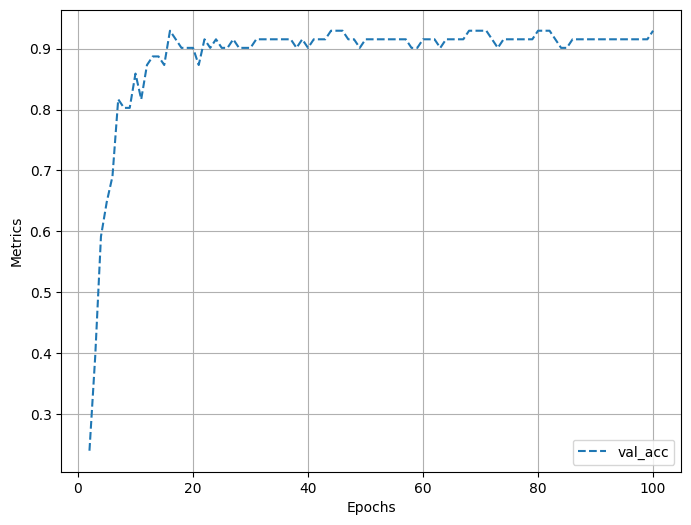

Results 
Acc: 0.9160. cohen kappa: 0.8960. Loss: 0.269297

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                 [-1, 1024]     102,761,472
             ReLU-14                 [-

100%|██████████| 201/201 [00:00<00:00, 11761.37it/s]


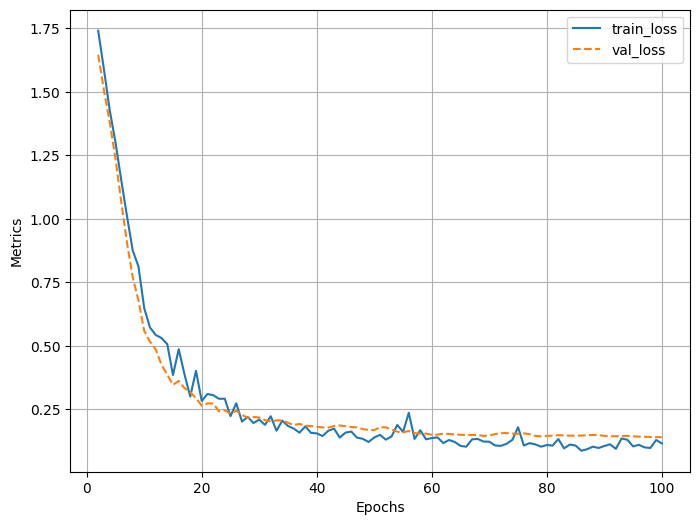

100%|██████████| 201/201 [00:00<00:00, 15319.64it/s]


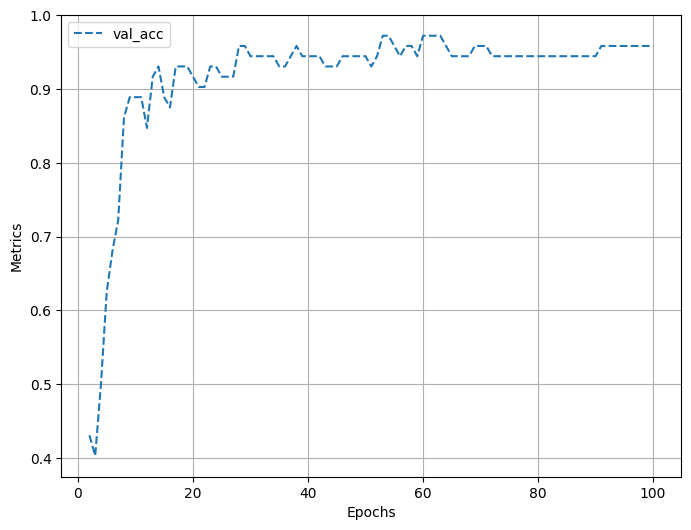

Results 
Acc: 0.9492. cohen kappa: 0.9372. Loss: 0.182326

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                 [-1, 1024]     102,761,472
             ReLU-14                 [-

100%|██████████| 201/201 [00:00<00:00, 15204.98it/s]


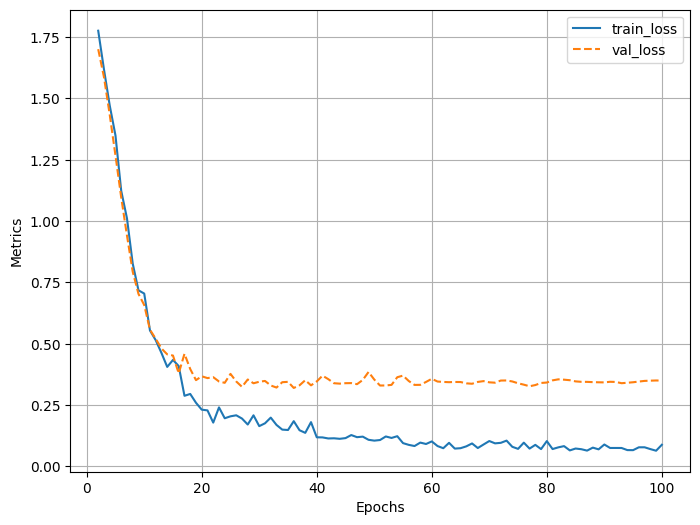

100%|██████████| 201/201 [00:00<00:00, 18999.28it/s]


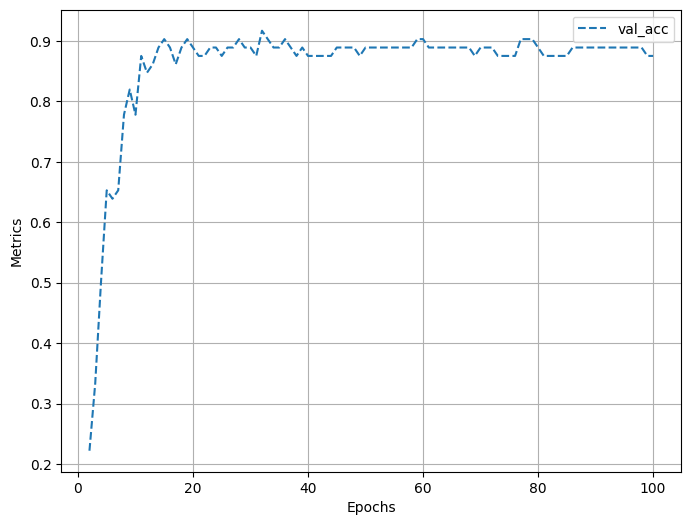

Results 
Acc: 0.8898. cohen kappa: 0.8634. Loss: 0.340102

In [ ]:
all_acc, all_cohen_kappa, all_per_class_r = [], [], pd.DataFrame()

for fold in range(n_fold):
    fold_dir = osp.join(dataset_dir, f'fold{fold}')
    fold_log_dir = osp.join(log_dir, f'fold{fold}')
    create_dir_if_necessary(fold_log_dir)

    best_model_path = osp.join(fold_log_dir, 'best_model.pth')

    if not test_only:
        train(fold_dir, fold_log_dir, best_model_path)
    gen_acc, gen_cohen_kappa, per_class_r = test(fold_dir, fold_log_dir, best_model_path)

    all_acc.append(gen_acc)
    all_cohen_kappa.append(gen_cohen_kappa)
    all_per_class_r = pd.concat((all_per_class_r, per_class_r), ignore_index=True)

In [ ]:
# 'class', 'acc', 'cohen_kappa'
all_per_class_r = all_per_class_r.groupby(by='class').agg(
    class_id=('class', 'last'),
    mean_acc=('acc', 'mean'),
    std_acc=('acc','std'),
    mean_kappa=('cohen_kappa', 'mean'),
    std_kappa=('cohen_kappa','std')
).reset_index(drop=True)

all_per_class_r.to_csv(osp.join(log_dir, 'per_class_result.csv'), index=False)

result = f"""Mean acc: f{np.mean(all_acc):.4f}. Std acc: f{np.std(all_acc):.4f}
Mean kappa: f{np.mean(all_cohen_kappa):.4f}. Std kappa: f{np.std(all_cohen_kappa):.4f}
"""
with open(osp.join(log_dir, 'results.txt'), 'w') as f:
    f.write(result)
print(result)

Mean acc: f0.9183. Std acc: f0.0243
Mean kappa: f0.8989. Std kappa: f0.0302

### Visualization

#### Projections

In [127]:
fold = 0
out_dir = osp.join(log_dir, f'fold{fold}')
cam_out_dir = osp.join(out_dir, 'cam')
create_dir_if_necessary(cam_out_dir)


best_model_dir = osp.join(out_dir, 'best_model.pth')
test_set = DataSet(osp.join(dataset_dir, f'fold{fold}', 'test'), transforms=val_transforms)
raw_test_set = DataSet(osp.join(dataset_dir, f'fold{fold}', 'test'))
test_loader = DataLoader(test_set)

model = get_model(params_dir=best_model_dir)
model.to(device)
_ = model.eval()


In [27]:
from collections import OrderedDict
import numpy as np

#get the outputs, and labels
def get_outputs(model, dataload, device):
    outputs_by_layer = None
    all_labels = None

    #get a batch from the dataload
    for inputs, labels in dataload:
        #move inputs to the correct device
        inputs = inputs.to(device)
        labels = labels.clone().detach().cpu().numpy()

        #get the activations for visualization
        outputs = model.get_output_per_layer(inputs)

        #save the outputs
        if outputs_by_layer is None:
            outputs_by_layer = outputs
            all_labels       = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate((outputs_by_layer[layer], outputs[layer]), axis=0)
            all_labels = np.concatenate((all_labels, labels))

    return outputs_by_layer, all_labels

#maps from high dimension to 2D
def projection(outputs_by_layer, reducer):
    projection_by_layer = OrderedDict()

    for layer in outputs_by_layer:
        #get the output of layer
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        #map to 2D
        embedded = reducer.fit_transform(output)
        #save projection
        projection_by_layer[layer] = embedded

    return projection_by_layer

#plot the projection of the output of each layer
def create_visualization(projection_by_layer, all_labels, out_dir):

    for layer in projection_by_layer:
        embedded = projection_by_layer[layer]

        fig = plt.figure(figsize=(8, 8))
        plt.scatter(embedded[:, 0], embedded[:, 1], c=all_labels, cmap=plt.get_cmap('tab10'))
        plt.axis("off")
        plt.title(layer)
        plt.colorbar()
        plt.savefig(osp.join(out_dir, layer)+'.pdf')
        plt.show()
        plt.close(fig)

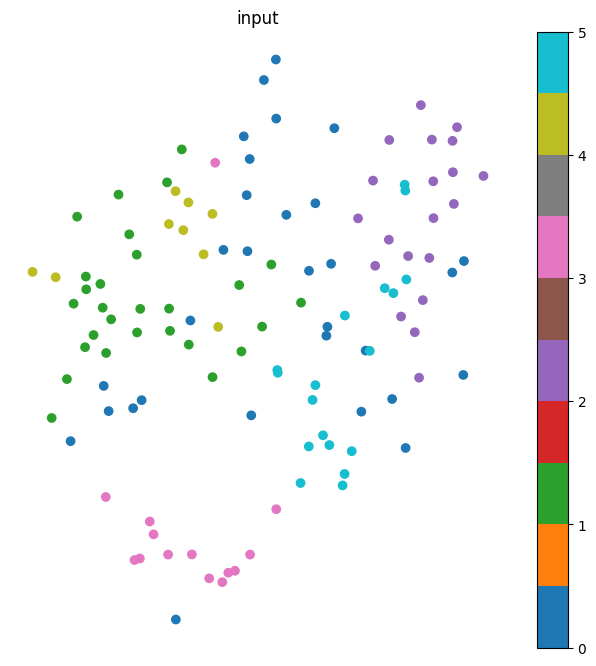

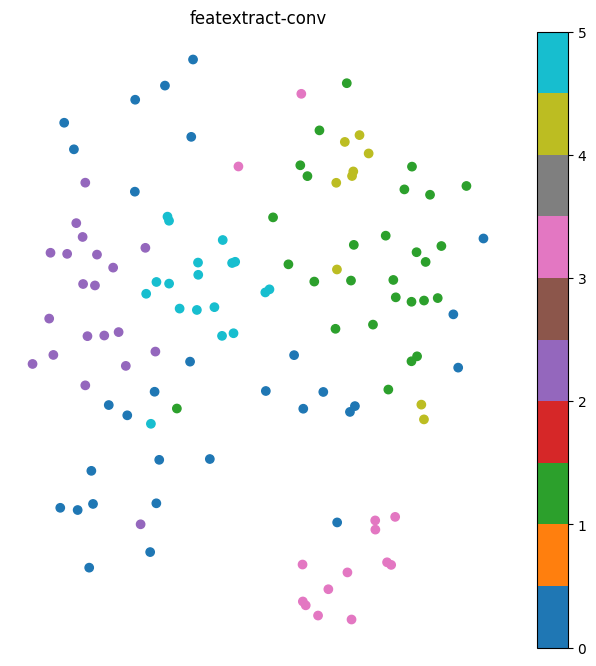

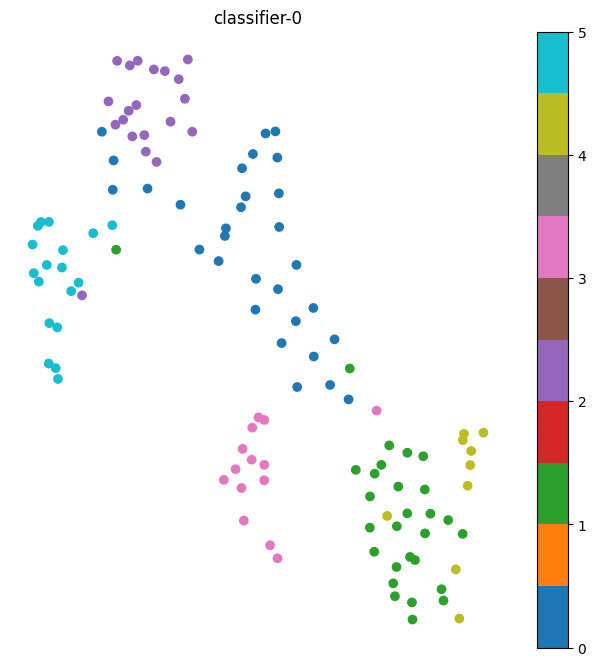

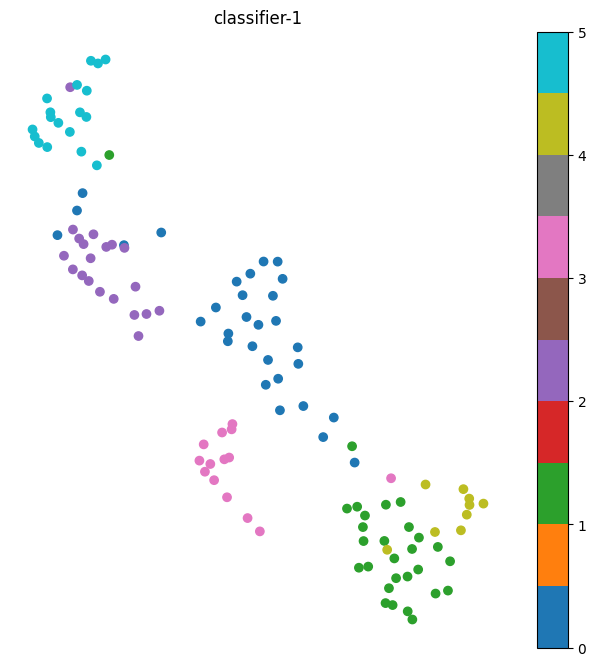

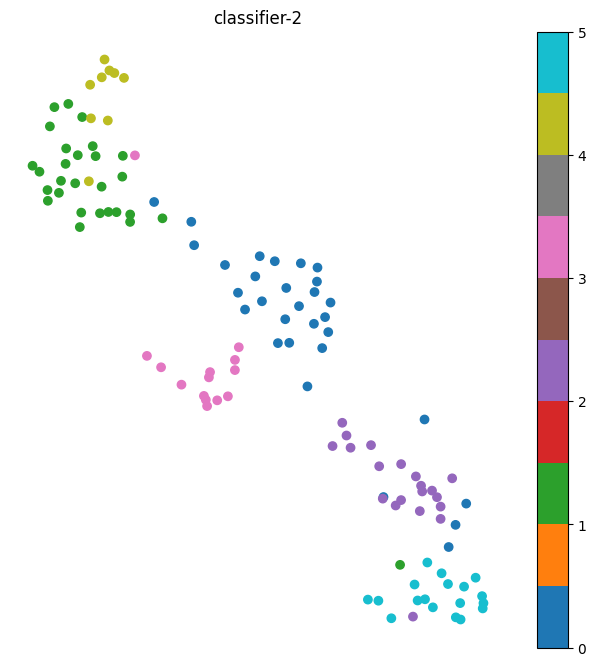

In [141]:
from sklearn.manifold import TSNE

#reducer = umap.UMAP()
reducer = TSNE(perplexity=30)


outputs_by_layer, all_labels = get_outputs(model, test_loader, device)
projection_by_layer = projection(outputs_by_layer, reducer)

prejection_out_dir = osp.join(out_dir, 'tsne')
create_dir_if_necessary(prejection_out_dir)
create_visualization(projection_by_layer, all_labels, prejection_out_dir)

#### GRAD_CAM

In [145]:


def get_output_of_the_model(model, x, device):
    # put the model in the evaluation mode
    model.eval()
    # move input tensor x to the selected device
    x = x.to(device)
    # execute the model with gradients
    output = model(x)
    return(output)

def get_heatmap(model, xin, device):
    # add one dimension (dim=0 must be the number of images)
    xin = xin.to(device)
    # get the output of the feature extractor
    activ  = model.get_conv_activation(xin)

    # compute gradients with respect to the most confident prediction
    model.zero_grad()

    # get the most confident prediction
    logits = get_output_of_the_model(model, xin, device)
    pred   = logits.max(-1)[-1]

    # get the predictions at the output of the decision layer
    logits[0,pred].backward(retain_graph=True)

    grad = model.get_conv_gradient()
    for i in range(activ.shape[1]):
        activ[:,i,:,:] *= grad[0][i].mean()

    heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

    # convert to numpy, normalize, and resize to the input size
    heatmap = heatmap.squeeze(0).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (xin.shape[3], xin.shape[2]))
    heatmap = np.maximum(heatmap, 0)
    return heatmap, pred

def save_image_with_heatmap(img, heatmap, scale, pred, label, out_dir, idx):
    heatmap = np.uint8(255.0*heatmap)
    width   = int(heatmap.shape[1]*scale)
    height  = int(heatmap.shape[0]*scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img     = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap*0.3 + img*0.7)

    name = osp.join(out_dir, f'{"c" if pred==label else "w"}_{label}_{idx:03d}.png')
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
    cv2.imwrite(name, heatmap)



In [146]:
import numpy as np

model.cam = True
model.to(device)

for idx, (x, true_label) in enumerate(test_loader):
    heatmap, pred = get_heatmap(model, x, device)
    x = np.array(raw_test_set[idx][0])

    save_image_with_heatmap(x, heatmap, 2, pred.item(), true_label.item(), cam_out_dir, idx)
